In [1]:
import numpy as np
from scipy.optimize import minimize

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit, Qubit, Instruction, Operation, CircuitInstruction
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile

from circuit_knitting.cutting import partition_problem, cut_gates, cut_wires

from cutter_search_manual import *
from resource_analysis import *
from automation import *

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

from azure.quantum import Workspace
from azure.quantum.target.microsoft import MicrosoftEstimator, ErrorBudgetPartition

workspace = Workspace (
   resource_id = "/subscriptions/e0d51919-2dda-4b7e-a8e7-77cc18580acb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QECBenchmarking",
   location = "uksouth"
)

estimator = MicrosoftEstimator(workspace)

In [4]:
second_order_formula = SuzukiTrotter()

L = 50
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(2):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
# print(
#     f"""
# Trotter step with Suzuki Trotter (2nd order)
# --------------------------------------------

#                   Depth: {circuit.depth()}
#              Gate count: {len(circuit)}
#     Nonlocal gate count: {circuit.num_nonlocal_gates()}
#          Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

# """
# )
# print(H)

circuit.draw("mpl")

In [7]:
from circuit_knitting.cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=20)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

Found solution using 16 cuts with a sampling overhead of 1853020188851841.0.
Gate Cut at circuit instruction index 114
Gate Cut at circuit instruction index 116
Gate Cut at circuit instruction index 234
Gate Cut at circuit instruction index 236
Gate Cut at circuit instruction index 324
Gate Cut at circuit instruction index 326
Gate Cut at circuit instruction index 384
Gate Cut at circuit instruction index 386
Gate Cut at circuit instruction index 555
Gate Cut at circuit instruction index 557
Gate Cut at circuit instruction index 675
Gate Cut at circuit instruction index 677
Gate Cut at circuit instruction index 765
Gate Cut at circuit instruction index 767
Gate Cut at circuit instruction index 825
Gate Cut at circuit instruction index 827


Found solution using 4 cuts with a samplingoverhead of 65536.
Wire Cut at circuit instruction index 3
Wire Cut at circuit instruction index 19
Wire Cut at circuit instruction index 23
Wire Cut at circuit instruction index 39


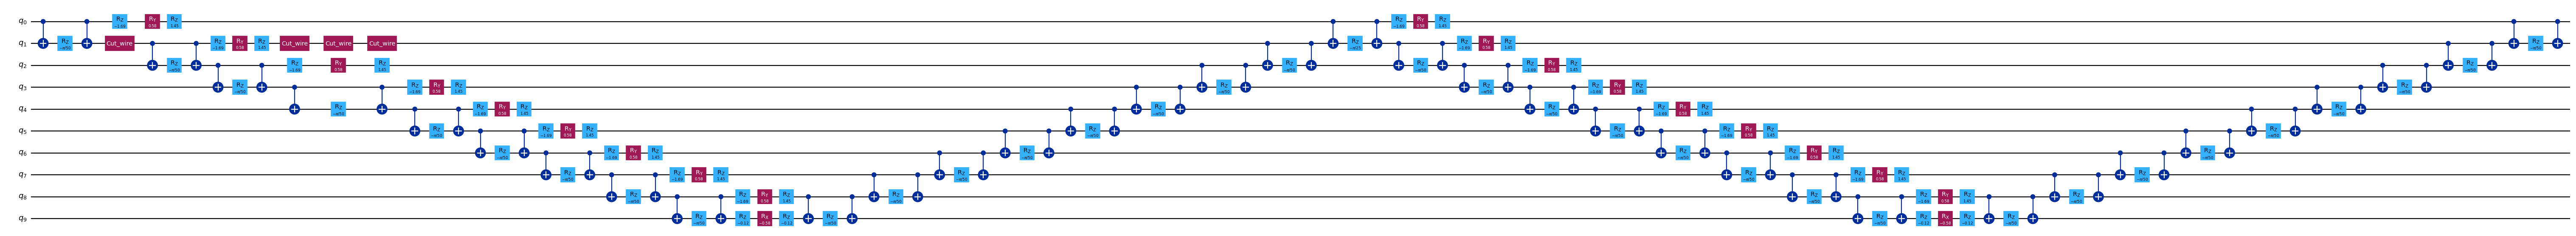

In [3]:
cut_circuit_dp, metadata = cuts(circuit,[],{3:[1],36:[1],17:[1],20:[1]})
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling'
    
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit_dp.draw("mpl", scale=0.8, fold=-1)

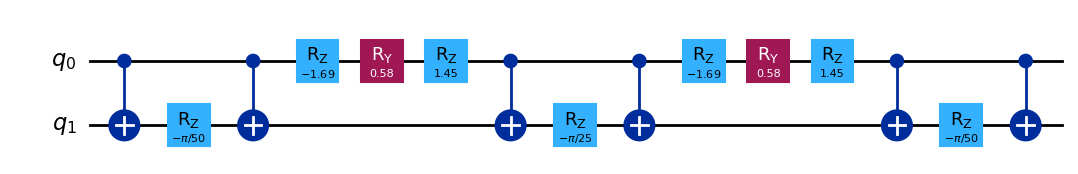

In [4]:

subcircuit = [QuantumCircuit(cut_circuit_dp.num_qubits-int(len(metadata["cuts"])/4)), QuantumCircuit(cut_circuit_dp.num_qubits-int(len(metadata["cuts"])/4))]
old_qubits = cut_circuit_dp.qubits
new_qubits = [c.qubits for c in subcircuit]
_Instruction = [[0,1,2,4,5,6,20,21,22, 24,25,26,40,41,42],[7,8,9,10,11,12,13,14,15,16,17,27,28,29,30,31,32,33,34,35,36,37,38]]
count = [0,0]
for idx, ins in enumerate(cut_circuit_dp.data):
    if idx in _Instruction[0]:
        if len(list(ins.qubits)) == 1:
            qb = new_qubits[0][old_qubits.index(ins.qubits[0])]
            subcircuit[0].data.insert(
                count[0],
                CircuitInstruction(
                    ins.operation,
                    [qb], []
                ),
                )  
        else:
            assert len(list(ins.qubits)) == 2
            qb1, qb2 = new_qubits[0][old_qubits.index(ins.qubits[0])], new_qubits[0][old_qubits.index(ins.qubits[1])]
            subcircuit[0].data.insert(
                count[0],
                CircuitInstruction(
                    ins.operation,
                    [qb1,qb2], []
                ),
                )   
        count[0] += 1
    elif idx in _Instruction[1]:
        if len(list(ins.qubits)) == 1:
            qb = new_qubits[1][old_qubits.index(ins.qubits[0])-1]
            subcircuit[1].data.insert(
                count[1],
                CircuitInstruction(
                    ins.operation,
                    [qb], []
                ),
                )  
        else:
            assert len(list(ins.qubits)) == 2
            qb1, qb2 = new_qubits[1][old_qubits.index(ins.qubits[0])-1], new_qubits[1][old_qubits.index(ins.qubits[1])-1]
            subcircuit[1].data.insert(
                count[1],
                CircuitInstruction(
                    ins.operation,
                    [qb1,qb2], []
                ),
                )   
        count[1] += 1
    else:
        continue
    
subcircuit[0].draw('mpl', fold=-1)

In [5]:
# # params = estimator.make_params(num_items=1)
# # # Error budget
# # params.error_budget = 0.01
# # params.constraints.max_t_factories = 1
# # job = estimator.submit(circuit, input_params=params)
# # r = job.get_results()
# # Q = r['physicalCounts']['physicalQubits']
# # T = r['physicalCounts']['runtime']*1e-3
# print('\n', 'total physical qubits required: ', Q, '\n', 'total runtime', T)
# total physical qubits required:  9384 
# total runtime 15210.800000000001

In [6]:
# params1 = estimator.make_params(num_items=2)
# params2 = estimator.make_params(num_items=2)
# params1.items[0].constraints.max_t_factories = 1
# params2.items[0].constraints.max_t_factories = 1
# params1.items[1].constraints.max_t_factories = 2
# params2.items[1].constraints.max_t_factories = 2
# for (e1, e2) in [(0.001,0.009),(0.002,0.008),(0.003,0.007),(0.004,0.006),(0.005,0.005),(0.006,0.004),(0.007,0.003),(0.008,0.002),(0.009,0.001)]:
#     params1.error_budget = ErrorBudgetPartition(e1/6, e1/3, e1/2) 
#     params2.error_budget = ErrorBudgetPartition(e2/6, e2/3, e2/2) 

#     job1 = estimator.submit(subcircuit[0], input_params=params1)
#     r1 = job1.get_results()
#     job2 = estimator.submit(subcircuit[1], input_params=params2)
#     r2 = job2.get_results()

#     print('\n', 'error partition 1/6 1/3 1/2 (max_T = 1): ', r1[0]['physicalCounts']['physicalQubits'], r1[0]['physicalCounts']['runtime']*1e-3, r2[0]['physicalCounts']['physicalQubits'], r2[0]['physicalCounts']['runtime']*1e-3)
#     print('\n', 'error partition 1/6 1/3 1/2 (max_T = 2): ', r1[1]['physicalCounts']['physicalQubits'], r1[1]['physicalCounts']['runtime']*1e-3, r2[1]['physicalCounts']['physicalQubits'], r2[1]['physicalCounts']['runtime']*1e-3)

#     params1.error_budget = ErrorBudgetPartition(e1/3, e1/3, e1/3) 
#     params2.error_budget = ErrorBudgetPartition(e2/3, e2/3, e2/3) 

#     job1 = estimator.submit(subcircuit[0], input_params=params1)
#     r1 = job1.get_results()
#     job2 = estimator.submit(subcircuit[1], input_params=params2)
#     r2 = job2.get_results()

#     print('\n', 'error partition 1/3 1/3 1/3 (max_T = 1): ', r1[0]['physicalCounts']['physicalQubits'], r1[0]['physicalCounts']['runtime']*1e-3, r2[0]['physicalCounts']['physicalQubits'], r2[0]['physicalCounts']['runtime']*1e-3)
#     print('\n', 'error partition 1/3 1/3 1/3 (max_T = 2): ', r1[1]['physicalCounts']['physicalQubits'], r1[1]['physicalCounts']['runtime']*1e-3, r2[1]['physicalCounts']['physicalQubits'], r2[1]['physicalCounts']['runtime']*1e-3)

#     params1.error_budget = ErrorBudgetPartition(e1/2, e1/3, e1/6) 
#     params2.error_budget = ErrorBudgetPartition(e2/2, e2/3, e2/6) 


#     job1 = estimator.submit(subcircuit[0], input_params=params1)
#     r1 = job1.get_results()
#     job2 = estimator.submit(subcircuit[1], input_params=params2)
#     r2 = job2.get_results()

#     print('\n', 'error partition 1/2 1/3 1/6 (max_T = 1): ', r1[0]['physicalCounts']['physicalQubits'], r1[0]['physicalCounts']['runtime']*1e-3, r2[0]['physicalCounts']['physicalQubits'], r2[0]['physicalCounts']['runtime']*1e-3)
#     print('\n', 'error partition 1/2 1/3 1/6 (max_T = 2): ', r1[1]['physicalCounts']['physicalQubits'], r1[1]['physicalCounts']['runtime']*1e-3, r2[1]['physicalCounts']['physicalQubits'], r2[1]['physicalCounts']['runtime']*1e-3)




In [12]:
def cost_function(sub_error_budget, subcircuit, overall_error):
    assert sum(sub_error_budget)*1e-4 - overall_error < 1e-3
    print(sum(sub_error_budget)*1e-4, sub_error_budget*1e-4)
    # if sum(sub_error_budget) - overall_error < 1e-6:
        # norm = sum(sub_error_budget)/overall_error
        # sub_error_budget = [s/norm for s in sub_error_budget]
    Q1 = PhysicalParameters.make_beverland_et_al(subcircuit[0], error_budget = [s*1e-4 for s in sub_error_budget[:3]]).Q
    Q2 = PhysicalParameters.make_beverland_et_al(subcircuit[1], error_budget = [s*1e-4 for s in sub_error_budget[3:]]).Q 
    # print('error partition: ', np.around(sub_error_budget,5).tolist(), ' (max_T_factories = 1), physical qubits difference: ', max([Q1,Q2])-Q)
    return max([Q1,Q2])


In [16]:
error_budget = [0.01/3]*3
Q = PhysicalParameters.make_beverland_et_al(circuit, error_budget=error_budget).Q
x0 = [sum(error_budget)*1e4/4,sum(error_budget)*1e4/12,sum(error_budget)*1e4/6, sum(error_budget)*1e4/6, sum(error_budget)*1e4/4, sum(error_budget)*1e4/12 ] 
bounds = [0,sum(x0)]
constraints_error = []
for i in range(len(x0)):
    lower, upper = bounds
    l = {'type': 'ineq', 'fun': lambda x, lb = lower, idx=i: x[idx] - lb }
    u = {'type': 'ineq', 'fun': lambda x, ub = upper, idx=i: ub - x[idx] }
    constraints_error.append(l)
    constraints_error.append(u)

constraints_error.append({'type': 'ineq', 'fun': lambda x: sum(x) - sum(x0)})
constraints_error.append({'type': 'ineq', 'fun': lambda x: sum(x0) - sum(x)})
# cost_function(x0, Q, subcircuit, sum(error_budget))
result = minimize(cost_function, x0, (subcircuit, sum(error_budget)), tol=1e-7, constraints=constraints_error, method='COBYLA')

0.01 [0.0025     0.00083333 0.00166667 0.00166667 0.0025     0.00083333]
0.010100000000000001 [0.0026     0.00083333 0.00166667 0.00166667 0.0025     0.00083333]
0.010100000000000001 [0.0025     0.00093333 0.00166667 0.00166667 0.0025     0.00083333]
0.010100000000000001 [0.0025     0.00083333 0.00176667 0.00166667 0.0025     0.00083333]
0.010100000000000001 [0.0025     0.00083333 0.00166667 0.00176667 0.0025     0.00083333]
0.010100000000000001 [0.0025     0.00083333 0.00166667 0.00166667 0.0026     0.00083333]
0.010100000000000001 [0.0025     0.00083333 0.00166667 0.00166667 0.0025     0.00093333]
0.0100125 [0.0025125  0.00083333 0.00166667 0.00166667 0.0025     0.00083333]
0.0100125 [0.0025     0.00084583 0.00166667 0.00166667 0.0025     0.00083333]
0.0100125 [0.0025     0.00083333 0.00167917 0.00166667 0.0025     0.00083333]
0.0100125 [0.0025     0.00083333 0.00166667 0.00167917 0.0025     0.00083333]
0.0100125 [0.0025     0.00083333 0.00166667 0.00166667 0.0025125  0.00083333]
0.0

In [17]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5362.0
       x: [ 2.500e+01  8.333e+00  1.667e+01  1.667e+01  2.500e+01
            8.333e+00]
    nfev: 55
   maxcv: -0.0

In [10]:
# def cost_function(sub_error_budget, Q, T, subcircuit, overall_error):
#     params1 = estimator.make_params(num_items=2)
#     params2 = estimator.make_params(num_items=2)
#     params1.items[0].constraints.max_t_factories = 1
#     params2.items[0].constraints.max_t_factories = 1
#     params1.items[1].constraints.max_t_factories = 2
#     params2.items[1].constraints.max_t_factories = 2

#     assert sum(sub_error_budget) - overall_error < 1e-6
#     # print(ErrorBudgetPartition(sub_error_budget[0], sub_error_budget[1], sub_error_budget[2]))
#     params1.error_budget = ErrorBudgetPartition(sub_error_budget[0], sub_error_budget[1], sub_error_budget[2]) 
#     params2.error_budget = ErrorBudgetPartition(sub_error_budget[3], sub_error_budget[4], sub_error_budget[5]) 

#     job1 = estimator.submit(subcircuit[0], input_params=params1)
#     r1 = job1.get_results()
#     job2 = estimator.submit(subcircuit[1], input_params=params2)
#     r2 = job2.get_results()
    
#     print('\n', 'error partition ', sub_error_budget[:3], ' (max_T = 1), physical qubits: ', max([r1[0]['physicalCounts']['physicalQubits'],r2[0]['physicalCounts']['physicalQubits']])-Q, 'runtime: ', r1[0]['physicalCounts']['runtime']*1e-3+r2[0]['physicalCounts']['runtime']*1e-3-T)
#     print('\n', 'error partition ', sub_error_budget[3:], ' (max_T = 2), physical qubits: ', max([r1[1]['physicalCounts']['physicalQubits'],r2[1]['physicalCounts']['physicalQubits']])-Q, 'runtime: ', r1[1]['physicalCounts']['runtime']*1e-3+r2[1]['physicalCounts']['runtime']*1e-3-T)

#     # return max([r1[0]['physicalCounts']['physicalQubits'],r2[0]['physicalCounts']['physicalQubits']])
#     return r1


In [11]:
# x0 = [params.error_budget/6]*6
# bounds = [0, params.error_budget]
# constraints_error = []
# for i in range(len(x0)):
#     lower, upper = bounds
#     l = {'type': 'ineq', 'fun': lambda x, lb = lower, idx=i: x[idx] - lb }
#     u = {'type': 'ineq', 'fun': lambda x, ub = upper, idx=i: ub - x[idx] }
#     constraints_error.append(l)
#     constraints_error.append(u)

# constraints_error.append({'type': 'ineq', 'fun': lambda x: sum(x) - params.error_budget})
# constraints_error.append({'type': 'ineq', 'fun': lambda x: params.error_budget - sum(x)})
# cost_function(x0, Q, T, subcircuit, params.error_budget)
# # result = minimize(cost_function, x0, (Q, T, subcircuit, params.error_budget), constraints=constraints_error, method='COBYLA')